In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [80]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise, Embedding, multiply, concatenate
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy, CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [4]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [5]:
train_imgs = []
train_classes = []
class_index = 0
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    print(f'{len(files)} samples in class {class_index}, ({root})')
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))
        train_classes.append(class_index)
    class_index += 1
train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5
train_classes = np.array(train_classes)

60 samples in class 0, (./CUB_200_2011/CUB_200_2011/images-cleaned/001.Black_footed_Albatross)
60 samples in class 1, (./CUB_200_2011/CUB_200_2011/images-cleaned/002.Laysan_Albatross)
58 samples in class 2, (./CUB_200_2011/CUB_200_2011/images-cleaned/003.Sooty_Albatross)
60 samples in class 3, (./CUB_200_2011/CUB_200_2011/images-cleaned/004.Groove_billed_Ani)
44 samples in class 4, (./CUB_200_2011/CUB_200_2011/images-cleaned/005.Crested_Auklet)
41 samples in class 5, (./CUB_200_2011/CUB_200_2011/images-cleaned/006.Least_Auklet)
53 samples in class 6, (./CUB_200_2011/CUB_200_2011/images-cleaned/007.Parakeet_Auklet)
48 samples in class 7, (./CUB_200_2011/CUB_200_2011/images-cleaned/008.Rhinoceros_Auklet)
59 samples in class 8, (./CUB_200_2011/CUB_200_2011/images-cleaned/009.Brewer_Blackbird)
60 samples in class 9, (./CUB_200_2011/CUB_200_2011/images-cleaned/010.Red_winged_Blackbird)
60 samples in class 10, (./CUB_200_2011/CUB_200_2011/images-cleaned/011.Rusty_Blackbird)
56 samples in cla

60 samples in class 98, (./CUB_200_2011/CUB_200_2011/images-cleaned/099.Ovenbird)
60 samples in class 99, (./CUB_200_2011/CUB_200_2011/images-cleaned/100.Brown_Pelican)
50 samples in class 100, (./CUB_200_2011/CUB_200_2011/images-cleaned/101.White_Pelican)
60 samples in class 101, (./CUB_200_2011/CUB_200_2011/images-cleaned/102.Western_Wood_Pewee)
60 samples in class 102, (./CUB_200_2011/CUB_200_2011/images-cleaned/103.Sayornis)
60 samples in class 103, (./CUB_200_2011/CUB_200_2011/images-cleaned/104.American_Pipit)
49 samples in class 104, (./CUB_200_2011/CUB_200_2011/images-cleaned/105.Whip_poor_Will)
60 samples in class 105, (./CUB_200_2011/CUB_200_2011/images-cleaned/106.Horned_Puffin)
59 samples in class 106, (./CUB_200_2011/CUB_200_2011/images-cleaned/107.Common_Raven)
60 samples in class 107, (./CUB_200_2011/CUB_200_2011/images-cleaned/108.White_necked_Raven)
60 samples in class 108, (./CUB_200_2011/CUB_200_2011/images-cleaned/109.American_Redstart)
60 samples in class 109, (./C

60 samples in class 191, (./CUB_200_2011/CUB_200_2011/images-cleaned/192.Downy_Woodpecker)
60 samples in class 192, (./CUB_200_2011/CUB_200_2011/images-cleaned/193.Bewick_Wren)
60 samples in class 193, (./CUB_200_2011/CUB_200_2011/images-cleaned/194.Cactus_Wren)
60 samples in class 194, (./CUB_200_2011/CUB_200_2011/images-cleaned/195.Carolina_Wren)
59 samples in class 195, (./CUB_200_2011/CUB_200_2011/images-cleaned/196.House_Wren)
60 samples in class 196, (./CUB_200_2011/CUB_200_2011/images-cleaned/197.Marsh_Wren)
60 samples in class 197, (./CUB_200_2011/CUB_200_2011/images-cleaned/198.Rock_Wren)
60 samples in class 198, (./CUB_200_2011/CUB_200_2011/images-cleaned/199.Winter_Wren)
60 samples in class 199, (./CUB_200_2011/CUB_200_2011/images-cleaned/200.Common_Yellowthroat)
0 samples in class 200, (./CUB_200_2011/CUB_200_2011/images-cleaned/)


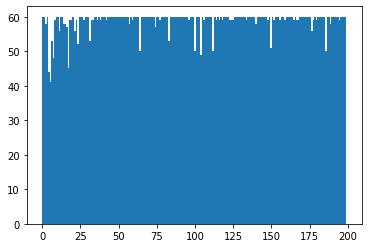

(11788, 64, 64, 3)


In [6]:
plt.hist(train_classes, bins=200)
plt.show()
assert(len(train_imgs) == len(train_classes))
print(train_imgs.shape)

In [72]:
def load_image_attributes():
    train_attrs = np.zeros((train_imgs.shape[0], 312))
    with open('./CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            # For now we don't care about attribute certainty, just if it is present.
            try:
                split = line.split()
                img_id = int(split[0])
                assert(img_id > 0)
                assert(img_id <= 11788)
                attr_id = int(split[1])
                assert(attr_id > 0)
                assert(attr_id <= 312)
                is_present = int(split[2])
                assert(is_present == 0 or is_present == 1)
            except: 
                print(line)
                print(line.split())
                return
            
            train_attrs[img_id-1, attr_id-1] = (2 * is_present) - 1
    return train_attrs

train_attrs = load_image_attributes().astype('float32')


In [8]:
def make_generator_model(shape):
    
    noise_in = Input(shape=shape)
    attributes_in = Input(shape=(312,))
    
    input_layer = multiply([noise_in, attributes_in])
    
    x = Dense(16*16*64*2)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 128))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model([noise_in, attributes_in], x)

In [9]:
generator = make_generator_model((312,))
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 312)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 312)]        0                                            
__________________________________________________________________________________________________
multiply (Multiply)             (None, 312)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32768)        10256384    multiply[0][0]               

(312,)


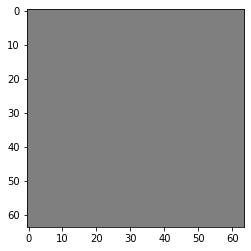

In [10]:
generator = make_generator_model((312,))

noise = np.random.normal(0, 1, 312)
label = train_attrs[0]
print(label.shape)

generated_image = generator.predict( [np.array([noise]), np.array([label])] )[0]
plt.imshow(unnormalize_img(generated_image), )

In [74]:
def make_valid_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', name='valid')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x) 
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(1, activation='sigmoid')(x)
    
    return Model(input_layer, valid)

In [12]:
discriminator_valid = make_valid_discriminator_model()
discriminator_valid.summary()
valid = discriminator_valid.predict(np.array([generated_image]))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [75]:
def make_attr_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', name='attr')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(312)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    valid = Dense(312, activation='tanh')(x)
    
    return Model(input_layer, valid)

In [14]:
discriminator_attr = make_attr_discriminator_model()
discriminator_attr.summary()
attrs = discriminator_attr.predict(np.array([generated_image]))


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0   

In [83]:
cross_entropy = BinaryCrossentropy(from_logits=False)

@tf.function
def discriminator_valid_loss(real_output, fake_output, flip):
    
    if flip:
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.9, maxval=1.0)
        real_labels = tf.random.uniform(real_output.shape, minval=0.0, maxval=0.1)
    else:
        real_labels = tf.random.uniform(real_output.shape, minval=0.9, maxval=1.0)
        fake_labels = tf.random.uniform(fake_output.shape, minval=0.0, maxval=0.1)

        
    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss, real_loss, fake_loss

In [97]:
mse = MeanSquaredError()

@tf.function
def discriminator_attribute_loss_real(real_output, real_attributes):
    return mse(real_output, real_attributes)

@tf.function
def discriminator_attribute_loss_fake(fake_output, fake_attributes):
    return mse(fake_output, fake_attributes)

In [98]:
@tf.function
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [99]:
@tf.function
def train_step(images, attrs, sampled_attrs, flip, warmup):
    noise = tf.random.truncated_normal([32, 312])
    
#     sampled_attrs = tf.cast(tf.random.uniform([32, 312], minval=0, maxval=2, dtype='int32'), 'float32') # Need to make this smarter. Only one 1 per attr.
    
#     attrs = tf.reshape(attrs, (attrs.shape[0], 1))
    
    gen_losses = []
    disc_losses = []
    disc_real_losses = []
    disc_fake_losses = []
    disc_attr_real_losses = []
    disc_attr_fake_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape_valid, tf.GradientTape() as disc_tape_attr:
        generated_images = generator([noise, sampled_attrs], training=True)
        
        real_output = discriminator_valid(images, training=True)
        fake_output = discriminator_valid(generated_images, training=True)
        
        real_attr_output = discriminator_attr(images, training=True)
        fake_attr_output = discriminator_attr(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_valid_loss, disc_real_loss, disc_fake_loss = discriminator_valid_loss(real_output, fake_output, flip)
        disc_attr_real_loss = discriminator_attribute_loss_real(real_attr_output, attrs)
        disc_attr_fake_loss = discriminator_attribute_loss_fake(fake_attr_output, sampled_attrs)
        disc_attr_loss = disc_attr_real_loss + disc_attr_fake_loss
#         disc_loss += ((2.0 - warmup) * disc_attr_real_loss + warmup * disc_attr_fake_loss)
        
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_valid_loss))
        disc_real_losses.append(K.mean(disc_real_loss))
        disc_fake_losses.append(K.mean(disc_fake_loss))
        disc_attr_real_losses.append(K.mean(disc_attr_real_loss))
        disc_attr_fake_losses.append(K.mean(disc_attr_fake_loss))
    
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator_valid = disc_tape_valid.gradient(disc_valid_loss, discriminator_valid.trainable_variables)
    
    gradients_of_discriminator_attr = disc_tape_attr.gradient(disc_attr_loss, discriminator_attr.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    discriminator_valid_optimizer.apply_gradients(zip(gradients_of_discriminator_valid, discriminator_valid.trainable_variables))
    
    discriminator_attr_optimizer.apply_gradients(zip(gradients_of_discriminator_attr, discriminator_attr.trainable_variables))

    return (gen_losses, disc_losses, disc_real_losses, disc_fake_losses, disc_attr_real_losses, disc_attr_fake_losses)

In [87]:
def train(train_imgs, train_attrs, epochs, warmup):
    gen_loss_all = []
    disc_loss_all = []
    disc_loss_real_all = []
    disc_loss_fake_all = []
    disc_attr_loss_real_all = []
    disc_attr_loss_fake_all = []
    warmup_step = 1./1000.
    
    num_samples = len(train_imgs)
    batch_counter = 0
    
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        disc_loss_real_epoch = [1, 0]
        disc_loss_fake_epoch = [1, 0]
        disc_attr_loss_real_epoch = [1, 0]
        disc_attr_loss_fake_epoch = [1, 0]
        
        seed = np.random.randint(0, 10000)
        np.random.seed(seed)
        np.random.shuffle(train_imgs)
        np.random.seed(seed)
        np.random.shuffle(train_attrs)
        
        for idx, i in enumerate(range(0, num_samples - 32, 32)):
            
            gen_loss_batch, disc_loss_batch, disc_loss_real_batch, disc_loss_fake_batch, disc_attr_loss_real_batch, disc_attr_loss_fake_batch = train_step(train_imgs[i:(i+32)], train_attrs[i:(i+32)], train_attrs[np.random.choice(range(len(train_attrs)), 32, replace=False)], batch_counter % 20 == 0, tf.constant(warmup, dtype='float32'))

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            disc_loss_real_epoch[0] += 1
            disc_loss_fake_epoch[0] += 1
            disc_attr_loss_real_epoch[0] += 1
            disc_attr_loss_fake_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            disc_loss_real_epoch[1] += np.mean(disc_loss_real_batch)
            disc_loss_fake_epoch[1] += np.mean(disc_loss_fake_batch)
            disc_attr_loss_real_epoch[1] += np.mean(disc_attr_loss_real_batch)
            disc_attr_loss_fake_epoch[1] += np.mean(disc_attr_loss_fake_batch)
            
            batch_counter += 1
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc valid loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}, Disc valid real loss: {disc_loss_real_epoch[1]/disc_loss_real_epoch[0]}, Disc valid fake loss: {disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0]}, Disc attr loss: {(disc_attr_loss_real_epoch[1] + disc_attr_loss_fake_epoch[1])/(disc_attr_loss_real_epoch[0])}, Disc attr real loss: {disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0]}, Disc attr fake loss: {disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
        disc_loss_real_all.append(disc_loss_real_epoch[1]/disc_loss_real_epoch[0])
        disc_loss_fake_all.append(disc_loss_fake_epoch[1]/disc_loss_fake_epoch[0])
        disc_attr_loss_real_all.append(disc_attr_loss_real_epoch[1]/disc_attr_loss_real_epoch[0])
        disc_attr_loss_fake_all.append(disc_attr_loss_fake_epoch[1]/disc_attr_loss_fake_epoch[0])
        
        if warmup < 1:
            warmup += warmup_step
    
    return (gen_loss_all, disc_loss_all, disc_loss_real_all, disc_loss_fake_all, disc_attr_loss_real_all, disc_attr_loss_fake_all, warmup)
    


In [92]:
def long_train(starting_checkpoint=0, num_checkpoints=0, checkpoint_interval=0, g_hist=None, d_hist=None, d_real_hist=None, d_fake_hist=None, d_attr_real_hist=None, d_attr_fake_hist=None, noise=None, attr=None, save_files=False, warmup=0.):
    
#     if noise is None:
#         noise = np.random.normal(0, 1, 100)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []
        
    if d_real_hist is None:
        d_real_hist = []
    
    if d_fake_hist is None:
        d_fake_hist = []
        
    if d_attr_real_hist is None:
        d_attr_real_hist = []
        
    if d_attr_fake_hist is None:
        d_attr_fake_hist = []

    for i in range(starting_checkpoint, starting_checkpoint + num_checkpoints):
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        print('')
        print(f'Starting checkpoint {i}')
        print('')
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
        
        gen_temp, disc_temp, disc_real_temp, disc_fake_temp, disc_attr_real_temp, disc_attr_fake_temp, warmup = train(train_imgs, train_attrs, checkpoint_interval, warmup)
        
        g_hist += gen_temp
        d_hist += disc_temp
        d_real_hist += disc_real_temp
        d_fake_hist += disc_fake_temp
        d_attr_real_hist += disc_attr_real_temp
        d_attr_fake_hist += disc_attr_fake_temp
        generated_image = generator.predict( [np.array([noise]), np.array([attr])])[0]
        plt.imshow(unnormalize_img(generated_image))
        if save_files:
            plt.savefig('./results/prog-imgs/bird-gan-attributes-split/' + str((i+1)*checkpoint_interval) + '.png')
        plt.show()
        if save_files:
            generator.save_weights('./results/weights/bird-gan-attributes-split/gen_weights_attributes_split_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_valid.save_weights('./results/weights/bird-gan-attributes-split/disc_weights_attributes_split_valid_' + str((i+1)*checkpoint_interval) + '.h5')
            discriminator_attr.save_weights('./results/weights/bird-gan-attributes-split/disc_weights_attributes_split_attr_' + str((i+1)*checkpoint_interval) + '.h5')
    
    return starting_checkpoint + num_checkpoints, totalepochs, warmup

In [95]:
discriminator_valid = make_valid_discriminator_model()
discriminator_attr = make_attr_discriminator_model()
generator = make_generator_model((312,))
generator_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_valid_optimizer = Adam(1e-4, beta_1=0.5)
discriminator_attr_optimizer = Adam(1e-4, beta_1=0.5)

In [96]:
# To get passed into training function and get modified
# Run cell when starting from scratch
gen_loss_hist = []
disc_loss_hist = []
disc_loss_real_hist = []
disc_loss_fake_hist = []
disc_attr_loss_real_hist = []
disc_attr_loss_fake_hist = []
noise312 = np.random.normal(0, 1, 312)
attr = train_attrs[0]
next_starting_checkpoint = 0
totalepochs = 0
warmup = 1.

In [387]:
next_starting_checkpoint, totalepochs, warmup = long_train(starting_checkpoint=next_starting_checkpoint, 
                                      num_checkpoints=10, 
                                      checkpoint_interval=100, 
                                      g_hist=gen_loss_hist, 
                                      d_hist=disc_loss_hist,
                                      d_real_hist=disc_loss_real_hist,
                                      d_fake_hist=disc_loss_fake_hist,
                                      d_attr_real_hist=disc_attr_loss_real_hist,
                                      d_attr_fake_hist=disc_attr_loss_fake_hist,
                                      noise=noise312,
                                      attr=attr,
                                      save_files=True,
                                      warmup=warmup)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Starting checkpoint 20

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Time for epoch 1 is 33.859846115112305 sec
Gen loss: 1.2110973464118109, Disc valid loss: 1.11606032253927, Disc valid real loss: 0.5690871814725199, Disc valid fake loss: 0.5469731420359314, Disc attr loss: 0.49554994375240513, Disc attr real loss: 0.17047716903331156, Disc attr fake loss: 0.32507277471909357
Time for epoch 2 is 33.918867111206055 sec
Gen loss: 1.2153676856500992, Disc valid loss: 1.1094351725849678, Disc valid real loss: 0.5688097870285272, Disc valid fake loss: 0.5406253832950179, Disc attr loss: 0.49640929347615903, Disc attr real loss: 0.17106934699424237, Disc attr fake loss: 0.32533994648191666
Time for epoch 3 is 33.90817832946777 sec
Gen loss: 1.2246152322466781, Disc valid loss: 1.112001499670954, Disc valid real loss: 0.5654592194208284, Disc valid fake loss: 0.5465422813000718, Disc attr loss: 0.49672370971379887, Disc attr real loss: 0.17137

KeyboardInterrupt: 

In [94]:
totalepochs

0

In [337]:
attr_df = pd.read_csv('CUB_200_2011/attributes.txt', sep=' ', header=None)
attr_df = attr_df.drop(0)
def description_from_vector(vec, df):
    indices = np.where(vec != 0)
#     s = ''
#     print(indices)
#     for idx in indices:
#         s += df[1][idx]
#     return s
    return df[1][indices[0]]
description_from_vector(attrs[0], attr_df)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64), array([  7,  20,  35,  52,  71,  75,  90, 104, 118, 133, 145, 151, 165,
       178, 195, 210, 212, 221, 235, 236, 240, 261, 292, 306, 308],
      dtype=int64))


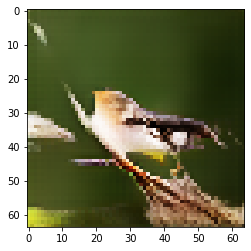

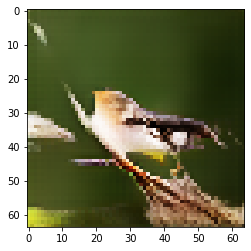

In [386]:
# attrs = train_attrs[np.random.choice(range(len(train_attrs)), 1, replace=False)]
noise = np.random.normal(0, 1, 312)
sweep = np.linspace(-1, 1, 2)
print(np.where(attrs == 1))

for d in sweep:
    attrs_copy = attrs.copy()
#     attrs_copy[0] *= -1
    generated_image = generator.predict([np.array([noise]), np.array([attrs_copy[0]])] )[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()


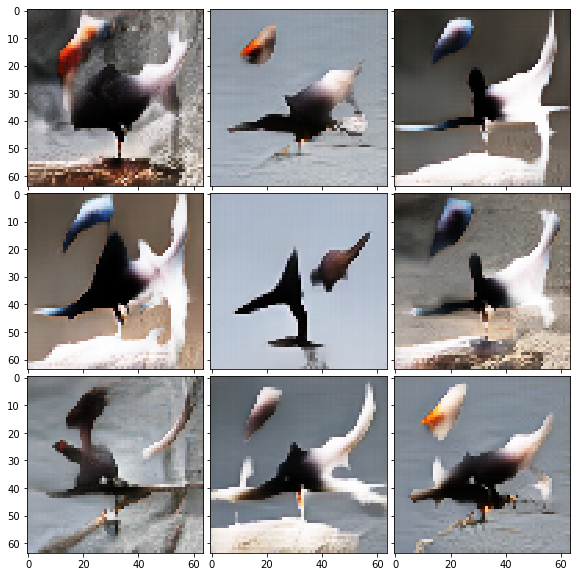

In [303]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

attrs = train_attrs[np.random.choice(range(len(train_attrs)), 9, replace=False)]
noise = np.random.normal(0, 1, 312)
for i, ax in enumerate(grid):
    generated_image = generator.predict([np.array([noise]), np.array([attrs[i]])] )[0]
#     plt.imshow(unnormalize_img(generated_image))
    ax.imshow(unnormalize_img(generated_image))

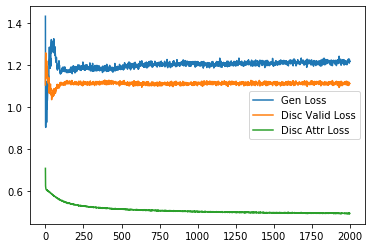

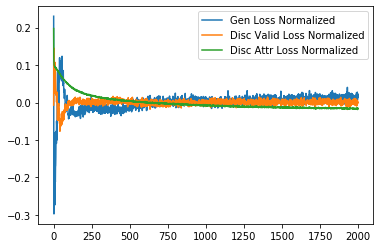

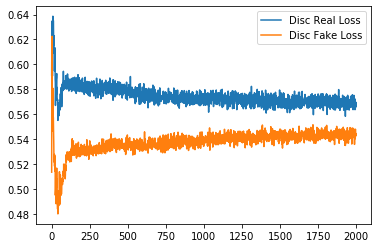

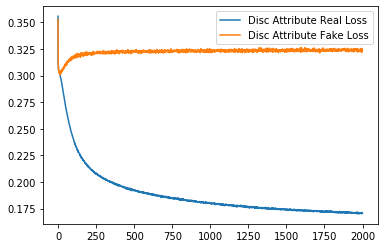

In [291]:
from operator import add
disc_attr_loss_hist = list( map(add, disc_attr_loss_real_hist, disc_attr_loss_fake_hist) )

plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.plot(disc_attr_loss_hist)

plt.legend(['Gen Loss','Disc Valid Loss', 'Disc Attr Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.plot(disc_attr_loss_hist - np.mean(disc_attr_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Valid Loss Normalized', 'Disc Attr Loss Normalized'])
plt.show()

plt.plot(disc_loss_real_hist)
plt.plot(disc_loss_fake_hist)
plt.legend(['Disc Real Loss','Disc Fake Loss'])
plt.show()

plt.plot(disc_attr_loss_real_hist)
plt.plot(disc_attr_loss_fake_hist)
plt.legend(['Disc Attribute Real Loss', 'Disc Attribute Fake Loss'])
plt.show()


In [ ]:
noise = tf.random.truncated_normal([32, 100])
tf.dtypes.cast(noise, tf.int32)


In [ ]:
for i in range(20,30):
    plt.imshow(unnormalize_img(train_imgs[i]))
    plt.title(img_classes[int(train_classes[i])])
    plt.show()

In [ ]:
intermediate_layer_model = Model(inputs=generator.input[1],
                                 outputs=generator.layers[2].output)


In [ ]:
total = None
for label in range(10):
    if total is None:
        total = np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
    total += np.abs(intermediate_layer_model.predict(np.array([label]))[0][0])
print(total)

In [ ]:
intermediate_layer_model.predict(np.array([0]))[0][0]

In [ ]:
test_gen = make_generator_model((100,))

In [ ]:
test_gen_embedding = Model(inputs=test_gen.input[1],
                                 outputs=test_gen.layers[2].output)

In [ ]:
test_gen_embedding.predict(np.array([7]))[0][0]

In [ ]:
for i in range(10):
    plt.imshow(unnormalize_img(train_imgs[i]))
    plt.title(img_classes[int(train_classes[i])])
    plt.show()